# Descarta de datos Sentinel
Actualmente se estan descargando los datos del satelite **Sentinel-2 y  Landsat 9**


**ESTABLECIMIENTO DE FECHAS DE INTERES**

In [2]:
from datetime import datetime

# Create a specific date and time
start_date = datetime(year=2024, month=10, day=1)  # Year, Month, Day, con un digito las que son de 1

# end date
end_date = datetime(year=2025, month=1, day=8)

**IMPORTACION DE LIBRERIAS**

In [3]:
import os
import json
import ee 
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap
import pandas as pd

In [4]:
# Extración de fechas
start_year = start_date.year
start_month = start_date.month
start_day = start_date.day

end_year = end_date.year
end_month = end_date.month
end_day = end_date.day

## Autentificación para GCP

In [5]:
# 1) Obtención de la dirección de trabajo 
direction = os.getcwd()

# Remove the last part of the path
direction = os.path.dirname(direction)

# Dirección de la llave 
service_account= direction + '/conf/local/gcp-for-data-science-397913-4fd843feede1.json'

# Autentificación 
credentials = ee.ServiceAccountCredentials(email=None,key_file=service_account)
ee.Initialize(credentials)

## 1) Importación del área de interés 
**NOTA:** Se obtiene el área de interés por medio de un archivo tipo Geojson, kml o shape. Para este ejemplo se utilizará un KML. 

### 1.1) Carga y visualización con geopandas

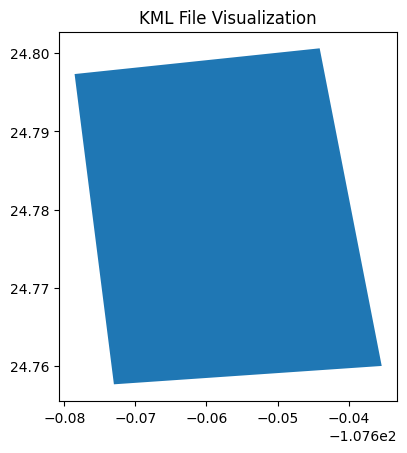

In [6]:
# Direction of the KML 
kml_file = direction + "/data/01_raw/Agricultura.kml"
# NOTA: Esto hay que pasarlo a otro notebook.

# Nombre del archivo GeoJson a exportar 
geojson_file = direction + "/data/01_raw/Agricultura.geojson"

# 1) Lectura del kml 
gdf = gpd.read_file(filename=kml_file, driver="KML")

# 2) Exportación del kml a un Geo JSON 
gdf.to_file(filename=geojson_file, driver="GeoJSON")

# Plot using Geopandas
gdf.plot()

# Customize the plot
plt.title("KML File Visualization")
plt.show()

## 2) Descarga de imagenes satelitales
En esta sección se abordarán los siguientes procesos 

- **[Creación de un geometria para Earth Engine](https://developers.google.com/earth-engine/apidocs/ee-geometry)**: La geometria de earth engine se puede crear a partir de un GeoJSON, esto serivara para hacer el corte en las imagenes satelitales de interés
  
- Descarga de datos satelitales para esa área junto con un filtro al área de intrés, fechas y nubosidad 

### 2.1) Creación de una geometría de earth engine 
Para la creación de una geometría lo más indicado es convertir el KML en un archivo GeoJSON y este leerlo directamtne como geometría 

In [7]:
# Step 1: Load the GeoJSON file
with open(geojson_file, "r") as f:
    geojson_data = json.load(f)

geojson_data["features"][0]["geometry"] # IMPORTANTE: Vease como contiene una tercera coordenada que es la altura (los valores de 0) , se deben de retirar 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008, 0.0],
   [-107.6353327971003, 24.76000824378666, 0.0],
   [-107.6440665193485, 24.80059938041618, 0.0],
   [-107.6785631858739, 24.79730942750482, 0.0],
   [-107.6730266244965, 24.75766085153008, 0.0]]]}

**Eliminación de la coordinada de elevación**

In [8]:
# Step 2: Function to remove the third dimension
def remove_third_dimension(geometry):
    """Removes the third dimension (z-values) from GeoJSON coordinates."""
    if geometry["type"] == "Polygon":
        geometry["coordinates"] = [
            [[coord[0], coord[1]] for coord in ring] for ring in geometry["coordinates"]
        ]
    elif geometry["type"] == "MultiPolygon":
        geometry["coordinates"] = [
            [[[coord[0], coord[1]] for coord in ring] for ring in polygon]
            for polygon in geometry["coordinates"]
        ]
    elif geometry["type"] == "LineString":
        geometry["coordinates"] = [[coord[0], coord[1]] for coord in geometry["coordinates"]]
    elif geometry["type"] == "Point":
        geometry["coordinates"] = geometry["coordinates"][:2]
    return geometry

# Step 3: Clean the geometry, ejecucón de la funcion 
cleaned_geometry = remove_third_dimension(geojson_data["features"][0]["geometry"])
cleaned_geometry # Vease ocmo aqui ya estan retirados la tercera dimensión de la altura 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008],
   [-107.6353327971003, 24.76000824378666],
   [-107.6440665193485, 24.80059938041618],
   [-107.6785631858739, 24.79730942750482],
   [-107.6730266244965, 24.75766085153008]]]}

**Convertir en geometría de Earth Engine**

In [9]:
# Step 4: Convert to Earth Engine Geometry
area_interest = ee.Geometry(cleaned_geometry)
type(area_interest)

ee.geometry.Geometry

### 2.2) Creación de un mapa base e integración de área de interés

**AÑADIMOS LA GEOMETRIA AL MAPA**

In [10]:
# 1) Creación del mapa base 
Map  = geemap.Map()

# Anadimos un base map distinto 
Map.add_basemap(basemap="Esri.WorldImagery")  # Imagene satelital de ESRI 

# 2) Add the geometry to the map
Map.addLayer(area_interest, {"color": "red"}, "Cleaned Geometry")

# Center the map on the geometry
Map.centerObject(area_interest, 11)

### 2.3) Descarga de imagenes satelitales

**IMPORTANTE:**
 Se hará la descarga de las imagenes en los años que se eligieron al inicio para los siguientes satelites:


- Sentinel 2:
  Bandas seleccionadas:
     - B2: Banda azul, central Wavelength = 490nm
     - B3: Banda verde, central Wavelength = 560nm
     - B4: Banda roja, central Wavelength = 665nm
     - B8: Banda Near Infrared, central Wavelength = 842nm, utilizada con algunas de las bandas RGB para el cálculo del NDVI
     - B11: Banda (SWIR 1), central Wavelength = 1610nm,  utilizada para el cálculo de NDWI

<br>

   - LandSat 9, bandas seleccionadas:
     - B10: Banda termica , utilizada para el cálculo de Land Surface Temperature


#### 2.3.1) Set up de filtros  

In [11]:
# 1) Importación del image collection de Copernicus
sentinel2 = ee.ImageCollection(args="COPERNICUS/S2_SR")

# 2) Filtro por área de interés
sentinel2 = sentinel2.filterBounds(geometry=area_interest)

# 3) Filtro por fechas de interés
sentinel2 = sentinel2.filterDate(start=f"{start_year}-{start_month}-{start_day}",
                                 end=f"{end_year}-{end_month}-{end_day}")  # año, mes y día


# 4) Filtro por titulo, IMPORATNTE: en el caso de Sentinel 2 apareceran 2 titulos de la misma imagen
sentinel2 = sentinel2.filter(ee.Filter.eq('MGRS_TILE', '12RZN'))

# 5) Filtro por nubosidad
sentinel2 = sentinel2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # nubosidad menor al 20%

# NOTE: This is still a image collection object

# 6) Seleccion Bandas necesarias
sentinel2 = sentinel2.select(['B2', 'B3', 'B4', 'B8', 'B11']) # Bandas de interes
type(sentinel2) # Esto es una image collection

ee.imagecollection.ImageCollection

#### 2.3.2) Obtención del ID de cada imagen y sus fechas

In [12]:
# Get the list of image IDs from the filtered ImageCollection
sentinel_images_ids = sentinel2.aggregate_array('system:index').getInfo()

# Cantidad de imagenes
number_sentinel = len(sentinel_images_ids)
print("Cantidad de imagenes de sentinel:", number_sentinel)

Cantidad de imagenes de sentinel: 16


**SENTINEL**

In [13]:
# Lista donde se almacenara el ID de las imagenes y su fecha
sentinel_ids_and_dates = []

#  Creación de la lista ee
sentinel_list = sentinel2.toList(sentinel2.size()) # Esto genera una ee list que contiene todo el listado de imagenes y metadados

for i in range(0,number_sentinel):
    # Aqui  se esta obteniedo cada imagen de la lista
    image = ee.Image(sentinel_list.get(i)) # Aqui hace la vinculación a una imagen en particula, en este caso toma la lista de ee y va tomar la imagen i, otra opcion tal vez mas sencilla de visualizar es usando directamtne el ID del a imagen (str)

    # Se toma el ID de la imagen
    image_id = image.get('system:index').getInfo()

    # Se toma la fecha de imagen
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    # Se integra los resultados a la lista
    sentinel_ids_and_dates.append({'ID': image_id, 'Date': date})

# Convertirlo a un pandas DF 
sentinel_ids_and_dates = pd.DataFrame(data=sentinel_ids_and_dates)
print("Cantidad de imagenes:", len(sentinel_ids_and_dates["Date"]))

# Tranformar la columna Date a tipo date
sentinel_ids_and_dates['Date'] = pd.to_datetime(arg=sentinel_ids_and_dates['Date'])
sentinel_ids_and_dates["Satelite"] = "COPERNICUS/S2_SR"
sentinel_ids_and_dates.head(n=5) # Visualizacion
# IMPORTQNTE: Vease que cada fecha tiene 2 imagenes, las inspecciones y son básicamente las mismas

Cantidad de imagenes: 16


,ID,Date,Satelite
0,20241004T174109_20241004T175248_T12RZN,2024-10-04,COPERNICUS/S2_SR
1,20241014T174209_20241014T174540_T12RZN,2024-10-14,COPERNICUS/S2_SR
2,20241019T174341_20241019T174809_T12RZN,2024-10-19,COPERNICUS/S2_SR
3,20241024T174319_20241024T175436_T12RZN,2024-10-24,COPERNICUS/S2_SR
4,20241029T174441_20241029T175146_T12RZN,2024-10-29,COPERNICUS/S2_SR


### 2.3.3) Solicitud de descarga

In [28]:
# 1) Creación de un diccionario vacio
sentinel_images_dic  = {}

# Inicio de la solocitud de descarga

for i in sentinel_ids_and_dates.index:
    # Extracción del ID de la imagen
    ID = sentinel_ids_and_dates["ID"].loc[i]

    # Extracción de la fecha de la imagen
    image_date = sentinel_ids_and_dates["Date"].loc[i]

    # Solicitud de descarga DESDE el IMAGE collection
    image = sentinel2.filter(ee.Filter.eq(name='system:index',value= ID)).first()

    # Recorte de la imagen usando la función de clip de ee
    image = image.clip(area_interest)  # Recorta al área de interés

    # 7) Almacenar en el diccionario
    sentinel_images_dic[f"Image_{image_date}"] = image

**PENDIENTE:**
- Hay que meter un filtro de nubosidad más estricto, que evaluemos la cantidad de nubes pero SOLO en la zona de interés.

In [18]:
## ES LO QUE ME PUSO EL CHAT PARA EL FILTRADO DE NUBES EN EL AREA DE INTERES 

#def cloud_percentage_in_aoi(image, aoi):
 #   """Calculate cloud percentage within the area of interest (AOI)."""
    # Mask clouds using QA60 band (1 = clouds, 0 = clear)
  #  cloud_mask = image.select('QA60').eq(1)
    
    # Calculate the total number of pixels in the AOI
   # total_pixels = ee.Number(image.clip(aoi).reduceRegion(
    #    reducer=ee.Reducer.count(),
     #   geometry=aoi,
      #  scale=10,
       # maxPixels=1e13
   # ).values().get(0))

    # Calculate cloud pixels in the AOI
   # cloud_pixels = ee.Number(cloud_mask.clip(aoi).reduceRegion(
    #    reducer=ee.Reducer.count(),
     #   geometry=aoi,
      #  scale=10,
       # maxPixels=1e13
   # ).values().get(0))
    
    # Calculate cloud percentage
   # cloud_percentage = cloud_pixels.divide(total_pixels).multiply(100)
   # return cloud_percentage

# Main script
#image_dic = {}  # Dictionary to store images

#for i in years:
 #   for z in months:
  #      if i <= current_year and z <= current_month:
            # 1) Import Sentinel-2 image collection
   #         sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    #            .filterBounds(area_interest) \
     #           .filterDate(f"{i}-{z}-01", f"{i}-{z}-28") \
      #          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # Rough initial filter
            
            # 2) Filter images based on AOI-specific cloud percentage
       #     def filter_by_aoi_cloud(image):
        #        cloud_percent = cloud_percentage_in_aoi(image, area_interest)
         #       return image.set('CLOUD_PERCENT_AOI', cloud_percent)
            
            # Apply AOI-specific cloud percentage calculation
          #  images_with_cloud_info = sentinel2.map(filter_by_aoi_cloud)

            # Filter images where AOI cloud coverage is less than 10%
  #          filtered_images = images_with_cloud_info.filter(ee.Filter.lt('CLOUD_PERCENT_AOI', 10))
            
            # Select the first image
   #         image = filtered_images.first()
            
            # Check if image exists and process
    #        if image.getInfo() is not None:
                # Select visible bands and band 8
     #           image = image.select(['B2', 'B3', 'B4', 'B8'])
      #          image = image.clip(area_interest)
                
                # Store the image
       #         image_dic[f"{i}-{z}"] = image
        #        print(f"Image for {i}-{z} meets cloud criteria in AOI.")
         #   else:
          #      print(f"No valid image found for {i}-{z}.")


## 3) Exportación 
La exportación la realizaremos a un bucket de GCP
 
API Reference: https://developers.google.com/earth-engine/apidocs/export-image-tocloudstorage#colab-python

**NOTA IMPORTANTE:** La exportación de las imagenes debe de cumplir ciertos requerimientos para que earth engine pueda aceder a ellos, los cuales son: 

It must be located in the US multi-region or US-CENTRAL1 region.

### 3.1) Exportación de imagenes Sentinel

In [26]:
# 1) Obtención de las llaves del diccionario
keys = list(sentinel_images_dic.keys())
sentinel_images_names =[]

# Inicio del ciclo 
for i in keys: 
    
    # 1) Lectura de los datos 
    image = sentinel_images_dic[i]
    
    task = ee.batch.Export.image.toCloudStorage(
    image=image,
    #description=f"Export", # Este es el nombre del archivo que se exportara , si vas a usar el filenameprexi no es necesario esto 
    bucket='earth_engine_selene',  # Cambia esto al nombre de tu bucket
    region = area_interest, # el parámetro region sirve para definir el área geográfica específica que se va a exportar.
    fileNamePrefix=f"sentinel2/Row_Data/{i}", # Damos una dirección dentro del bucket y le damos nombre
    scale=10,  # Resolución en metros
    fileFormat='GeoTIFF')  # Formato de archivo
    
    task.start()  # Inicia la tarea de exportación
    print("Se exportó la imagen a Cloud Storage:", i)    
    
    # Image name
    name = f"{i}"
    sentinel_images_names.append(name)

Se exportó la imagen a Cloud Storage: Image_2024-10-04 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-14 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-19 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-24 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-10-29 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-03 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-08 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-13 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-18 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-23 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-11-28 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-03 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-18 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-23 00:00:00
Se exportó la imagen a Cloud Storage: Image_2024-12-28 00:00:00
Se exportó la imagen a Cloud Storage: Im

### 3.2) Exportación de mapa html 
Este mapa contiene las capas agregadas, en este caso solo el área de interés 

In [21]:
# Visualizacion del mapa en un broswer 
html_file = direction + "/data/02_intermediate/Map.html" # String de la direccion de exportacion
Map.to_html(filename=html_file, title="My Map", width="100%", height="880px") # Exporacion a una html 
# NOTA : En estos momentos solo agrege el area de interes, no estan las imagenes TIF 

### 3.3) Exportación del nombre de las imagenes 
Esto lo utilizaremos pasa saber exactamente que es lo que se exporto al bucket 

In [23]:
# 1) Creación del pandas DF 
names = pd.DataFrame(data=sentinel_images_names, columns=["Images names"])

# 2) Exportación a csv 
names.to_csv(path_or_buf=direction + "/data/02_intermediate/sentinel_images_names.csv", index=False)